# INTELLIGENT SYSTEMS AND ROBOTICS (MSDS 464)
## OCR Text Recognition
    MacOS Setup
    Submit following commands from the terminal window
     conda install -c ijstokes pytesseract
     Note Install Homebrew if not install
         brew link libtiff
         brew link libpng
         brew link jpeg
         brew install tesseract --all-languages

### 1. Image preprocessing with OpenCV
### ---- Image scaling to 300 dpi
### ---- Skew Correction: text box detection and rotation
### ---- Noise Removal or Denoise with Gaussian function
### 2. Optical text recognition with deep learning pre-trained model tesseract  


In [1]:
%matplotlib inline

In [2]:
import cv2
import sys
!{sys.executable} -m pip install pytesseract
import pytesseract
from PIL import Image
import tempfile
import numpy as np
!{sys.executable} -m pip install imutils
import imutils
import argparse
import os
import ntpath
from pathlib import Path
from matplotlib import pyplot as plt

In [3]:
folderPath = Path('test images')
saveFolder = "output"  

#convertedImageList = []
resizedImageList = []
binarizedImageList = []
threshHoldList = []
deskewedImageList = []
noiseRemovalImageList = []

#imageList is a list of all non-folder files in filePath directory
if folderPath.is_dir():
    originalImageList = list(x for x in folderPath.iterdir() if x.is_file())

In [4]:
######### Scaling of image:
######### Image Rescaling is important for image analysis. 
######### Mostly OCR engine give an accurate output of the image which has 300 DPI. 
######### DPI describes the resolution of the image or in other words, it denotes printed dots per inch.
def resizeImage(file_path):
    im = Image.open(file_path)
    length_x, width_y = im.size
    factor = min(1, float(1024.0 / length_x))
    size = int(2 * length_x), int(2 * width_y)
    im_resized = im.resize(size, Image.ANTIALIAS)
    temp_file = tempfile.NamedTemporaryFile(delete=False,   suffix='.png')
    temp_filename = temp_file.name
    im_resized.save(temp_filename, dpi=(400, 400))
    
    return temp_filename

In [5]:
def binarizeImage(file_path):
    im = cv2.imread(file_path)
    # convert the image to grayscale and flip the foreground
    # and background to ensure foreground is now "white" and
    # the background is "black"
    grey = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    grey = cv2.bitwise_not(grey)
    #threshold set at 100 - might be worth changing
    thresh = cv2.threshold(grey, 100, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    
    threshHoldList.append(thresh)
    
    temp_file = tempfile.NamedTemporaryFile(delete=False, suffix='.png')
    temp_filename = temp_file.name
    img = Image.fromarray(thresh)
    img.save(temp_filename)
    
    return temp_filename

In [6]:
def deskewImage(file_path, index):
    im = cv2.imread(file_path)
    # grab the (x, y) coordinates of all pixel values that
    # are greater than zero, then use these coordinates to
    # compute a rotated bounding box that contains all
    # coordinates
    coords = np.column_stack(np.where(threshHoldList[index] < 100))
    angle = cv2.minAreaRect(coords)[-1]

    # the `cv2.minAreaRect` function returns values in the
    # range [-90, 0); as the rectangle rotates clockwise the
    # returned angle trends to 0 -- in this special case we
    # need to add 90 degrees to the angle
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle

    # rotate the image to deskew it
    (h, w) = im.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(im, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

    temp_file = tempfile.NamedTemporaryFile(delete=False,   suffix='.png')
    temp_filename = temp_file.name
    cv2.imwrite(temp_filename, rotated)
    
    return temp_filename

In [7]:
def removeNoise(file_path):
    #image must be loaded as greyscale for equalizeHist to work
    img = cv2.imread(file_path, 0)
    #img = cv2.imread(file_path)
    #equalizeHist = cv2.equalizeHist(img)
    #edges = cv2.Canny(img, 100, 350)
    ret2,th2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    #th3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
    
    #blur = cv2.GaussianBlur(img,(5,5),0)
    #ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    temp_file = tempfile.NamedTemporaryFile(delete=False,   suffix='.png')
    temp_filename = temp_file.name
    cv2.imwrite(temp_filename, th2)
    
    return temp_filename

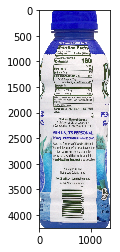

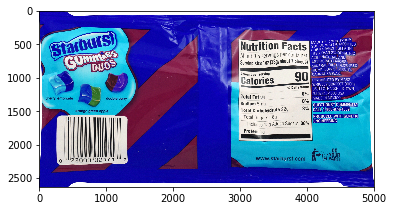

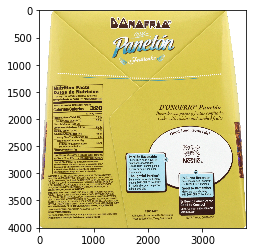

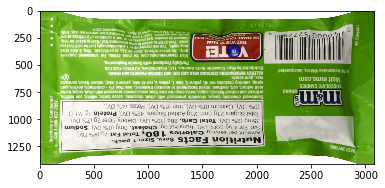

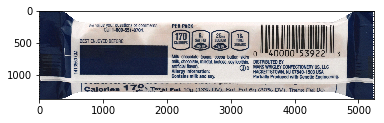

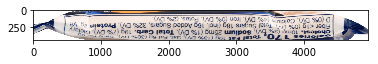

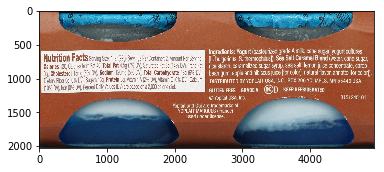

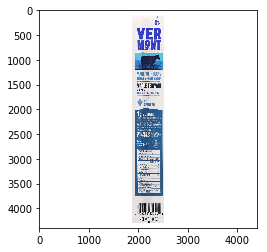

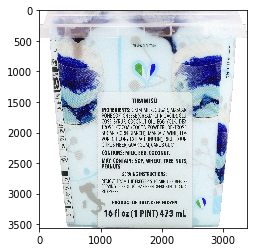

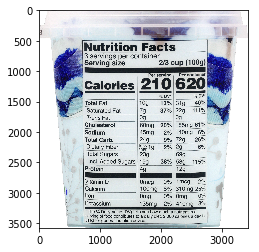

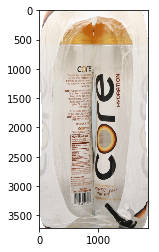

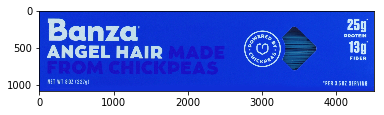

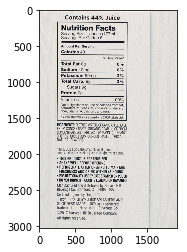

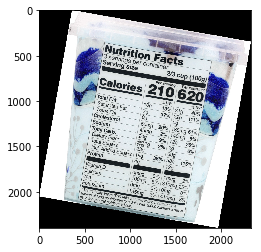

In [8]:
#Resize Image
if __name__ == '__main__':
    for x in originalImageList:
        y = resizeImage(x)
        resizedImageList.append(y)
        img = cv2.imread(y,1)
        plt.imshow(img)
        plt.show()

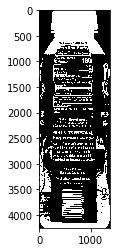

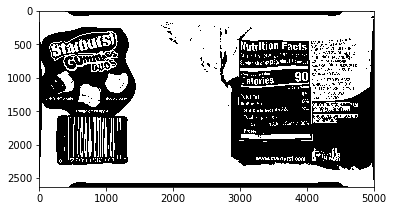

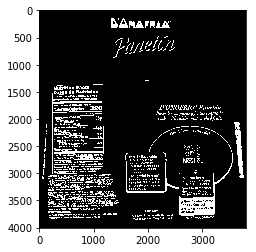

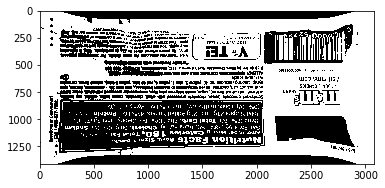

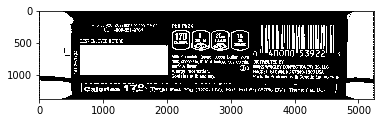

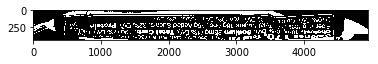

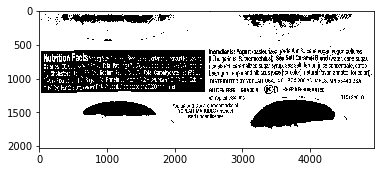

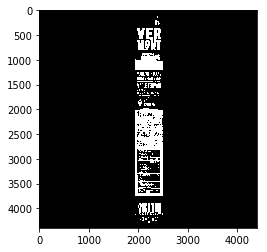

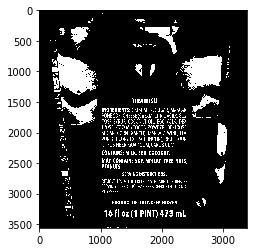

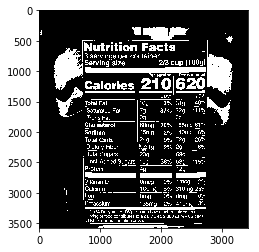

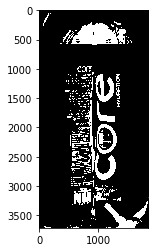

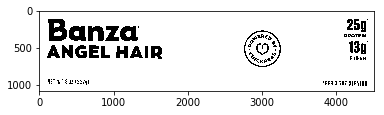

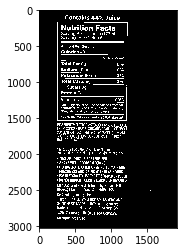

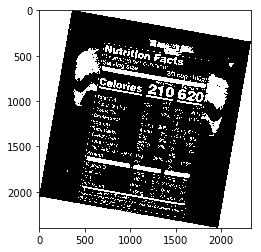

In [9]:
#Binarize Image
for x in resizedImageList:
    y = binarizeImage(x)
    binarizedImageList.append(y)
    img = cv2.imread(y,1)
    plt.imshow(img)
    plt.show()

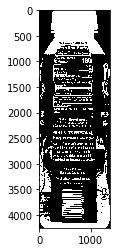

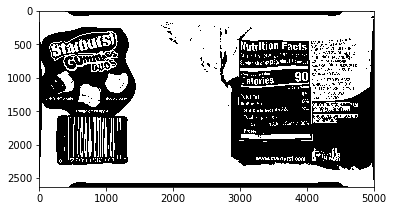

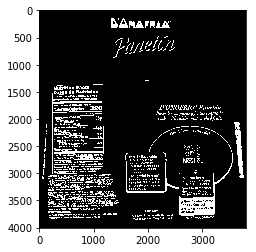

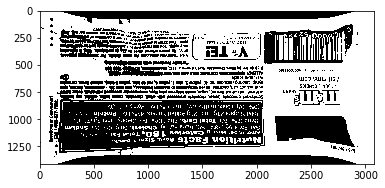

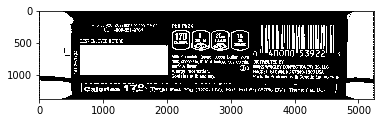

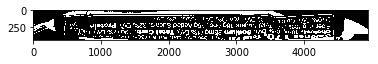

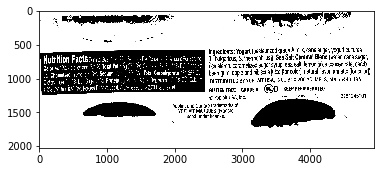

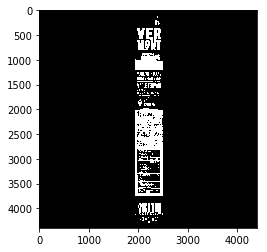

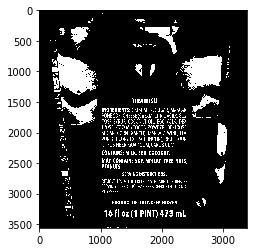

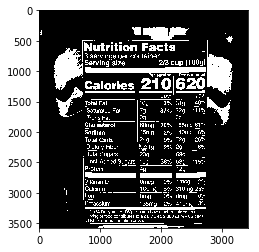

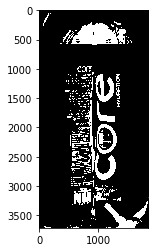

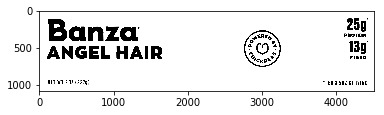

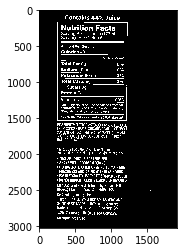

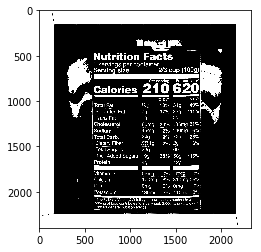

In [10]:
#Deskew Image
for x in range (len(binarizedImageList)):
    y = deskewImage(binarizedImageList[x], x)
    deskewedImageList.append(y)
    img = cv2.imread(y,1)
    plt.imshow(img)
    plt.show()

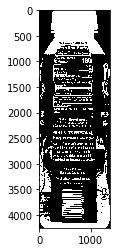

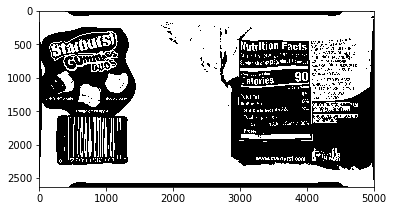

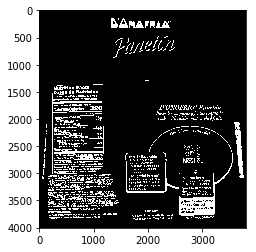

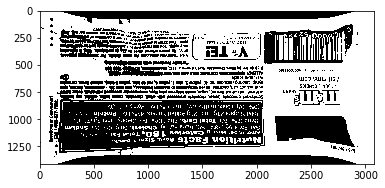

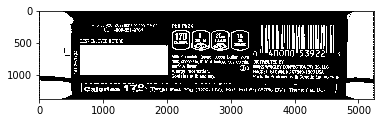

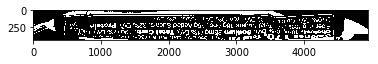

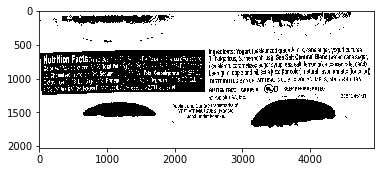

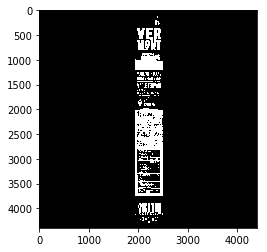

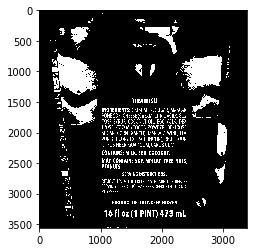

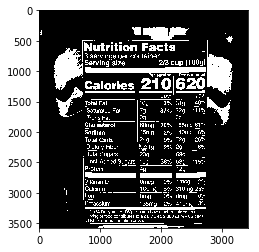

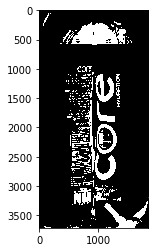

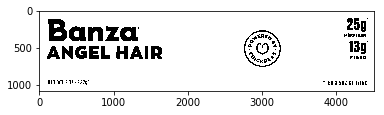

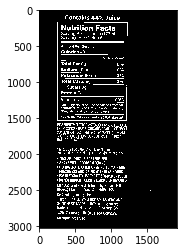

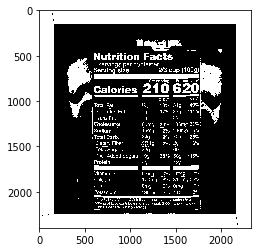

In [11]:
#Remove noise
for x in deskewedImageList:
    y = removeNoise(x)
    noiseRemovalImageList.append(y)
    img = cv2.imread(y,1)
    plt.imshow(img)
    plt.show()

In [12]:
#Generates output text files
if __name__ == '__main__':
    #export to file or print output here:
    for i in range(0, len(noiseRemovalImageList)):
        file_path = noiseRemovalImageList[i]
        # Define config parameters.
        # '-l eng'  for using the English language
        # '--oem 1' for using LSTM OCR Engine
        config = ('-l eng --oem 1 --psm 3')
        # Read image from disk
        im = cv2.imread(file_path, cv2.IMREAD_COLOR)
        # Run tesseract OCR on image
        text = pytesseract.image_to_string(im, config=config)
        
        #output files names are based on input file names, however the .png replaced with .txt, might needed editing if input
        #file formats ever differ
        temp = ntpath.basename(noiseRemovalImageList[i])
        temp = temp.replace(".png", ".txt")
        temp = temp.replace(".jpg", ".txt")
        temp = temp.replace(".gif", ".txt")
        completePath = os.path.join(os.getcwd(), saveFolder, temp)
        outFile = open(completePath, 'w')
        outFile.write(text)
        outFile.close()
        
        print("========================================")
        print(text)
        print("========================================")

a

   
 
 

Tr TT Oe

Total Carbohydrate 389 1
Total Sugars 359

TS Basle eR ee 2

  

 

WOE ee laser Cacm msl ET CURE L
CLAUS COGN At mee TEM mer Cert
Ue ly

*%DV = %Daily Value
OS at aie lesa

p> ™ @ PR

Florida’s Natural Growers |
its A division of Citrus World, Inc. ay
A Cooperative in Lake Wales, FL 33853

WITH US, ITS PERSONAL _
: Tatswhy Florida’s Natural tastes so good. Shs

P Weare the farmers of Florida’s Natural.
“ Oe Ati) cut Sulla kan UL
Dea eRe Res allen

“4 Cooling rain. And that makes our juice

   
  

  
  

Cont

 
  
  
 
 
 

 

No Sugar Added
Not a Low Calorie Food

SHAKE WELL « Keep Refrigerated
© 2017 Florida's Natural
Beene at

orange green apple

my

 

‘ 4S yt
oy

 
     
   

OF: CORN SYRUP,
MADE waTeR. MODIFIED

G :
Sue STARCH, GELATIN:
LESS THAN 2% OF: QURIC ~
ACID. NATURAL AND Sa”

if hie ce

ae About 3.5 servings Per container

   
      
   
    
  

 
  

4

"27. ae IE VUUMNCYSS ARTIFICIAL FLAVORS, ~’

5 & Serving size 102 (209 | MINERAL OIL, COLOR (R

25

PROTEIN

13

FIBER

Banza
ANGEL HAIR

NET WT 802 (2279) “PER 3.502 SERVING
Contains 44% Juice

Nutrition Facts

Serving Size 1 pouch (177mL)
Servings Per Carton 8

Amount Per Serving
Calories 40

% Daily Value”
Total Fat 0g 0%
Sodium 10mg 0%

Potassium 90mg 3%

Total Carb. 9g 3%
Sugars 9g

Protein 0g

DY
Vitamin C 100%

Not a significant source of calories from fat,
saturated fat, trans fat, cholesterol, dietary
fiber, vitamin A, calcium, and iron.

“Percent Daily Values are based on a 2,000 calorie diet.

DS a aaa U ane es
ROAR aR UOC Oma m0] meas 10
CONCENTRATE, ASCORBIC ACID (VITAMIN vt eee
CHERRY JUICE FROM CONCENTRATE, CITRIC ACID.
NATURAL FLAVORS.

 

MUSOU RS) CUE ROTC ISSO RO CLUS

eT OOM UTR ar eae SOL SIT1e

¢ THIS PRODUCT IS PASTEURIZED

e SHAKE WELL BEFORE OPENING

¢ REFRIGERATE AFTER OPENING TO MAINTAIN
Sa Lae eh

a RUA Sa ae a Pee

* DO NOT DRINK IF POUCH IS LEAKING OR DAMAGED

Manufactured and distributed by Harvest Hill

Beverage Co. Stamford, CT 06905, USA

Cairo R